# <center> Applications of No-Collision Transportation Maps in Manifold Learning <center>
This notebook provides the main code to implement the no-collison map algorithm  from the paper "E. Negrini, L. Nurbekyan, Applications of No-Collision Transportation Maps in Manifold Learning." 
The paper can be found here: 

For the comparison wirh Wassmap and LOT we use the original code provided in the corresponding papers:



# <center> Translation Examples, Section 7.1 <center>

In [1]:
############## Import statements ########################

import sklearn
import numpy as np
import ot
import ot.plot

# networkx is a graph library 
import networkx as nx

import time

from sklearn import manifold as man
from sklearn.decomposition import PCA
from pydiffmap import diffusion_map as dm

import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.sparse
from pydiffmap import diffusion_map as dm


# NOTE: RBFInterpolator needs scipy>=1.7.0
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator
#from scipy.interpolate import RBFInterpolator

import math



from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator

from mpl_toolkits.axes_grid1 import ImageGrid

#LOT functions
from Functions.LOT_ML import *
from Functions.Gaussians import *



#No-collision functions
from Functions.no_collision import *

#Wassmap functions
from Functions.WassmapFunctions import *

#Data generator
from Functions.DataGenerator import *


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-30 01:12:34.382014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 01:12:34.579763: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-30 01:12:35.311158: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file

In [2]:
########## global figure settings ####################

%matplotlib inline
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
        'axes.titlesize': 20
         }

plt.rcParams.update(params)
 
font = {'family':'serif','weight':'normal','size':18}
plt.rc('font',**font)


## Translation Manifold, Example 1, Section 7.1.1

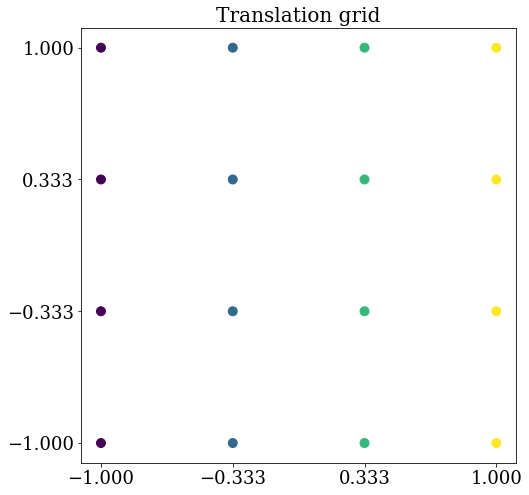

In [3]:
############# Translation Grid Genaration #########################

num_samplepoints = 32
circ = generate_circle([0,0],1,samples=num_samplepoints)

# Generate translation set
num_translates = 4
num_samp = num_translates**2
x = np.linspace(-1,1,num=num_translates)
y = np.linspace(-1,1,num=num_translates)
xx,yy = np.meshgrid(x,y) #num_translates x num_translates matrices; each xx,yy entry is a translation vector
xx = np.reshape(xx,(num_translates**2,1))
yy = np.reshape(yy,(num_translates**2,1))
translates = np.zeros((num_translates**2,2))
for i in range(len(xx)):
    translates[i,0] = xx[i]
    translates[i,1] = yy[i]
    
# Plot the translation set
fig1,ax1 = plt.subplots();
ax1.scatter(translates[:,0],translates[:,1],s=80, c = translates[:,0], cmap = 'viridis');
ax1.set_aspect('equal');
ax1.set_title('Translation grid')
ax1.set_xticks(x);
ax1.set_yticks(y);
    

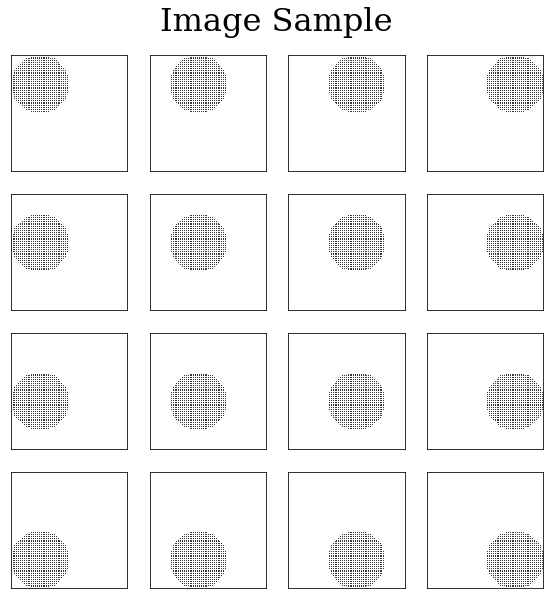

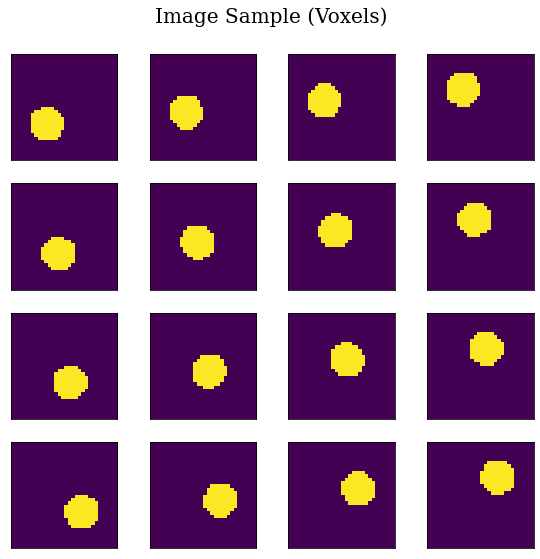

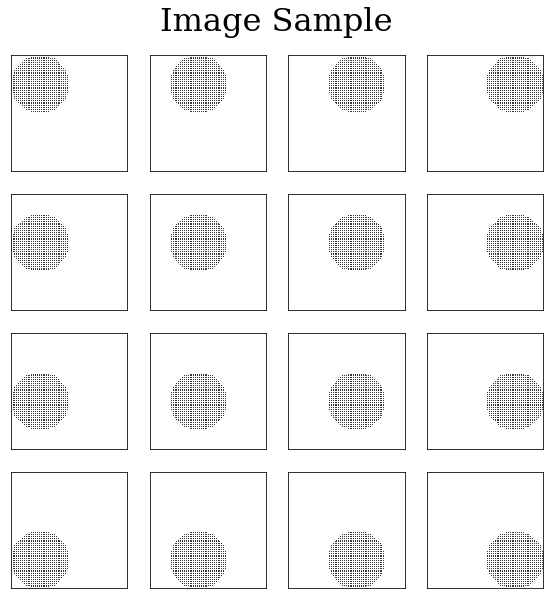

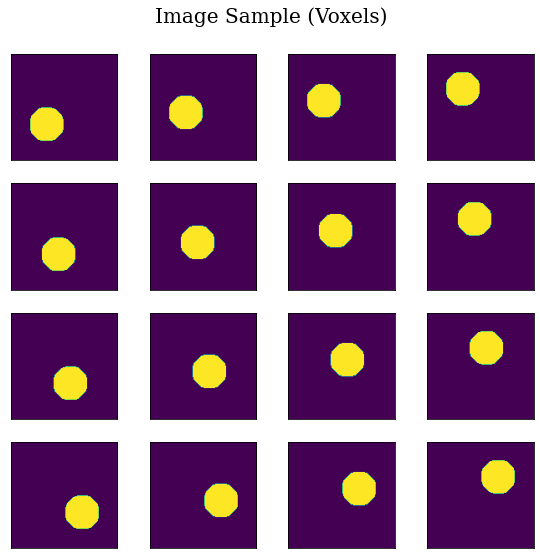

In [4]:
################# Translated images and image tensor generation #######################
trans_images = []
for i in range(num_translates**2):
    img = np.concatenate((translation(circ,[translates[i,0],translates[i,1]]),np.ones((circ.shape[0],1))/circ.shape[0]),axis=1)
    trans_images.append(img)

def voxel(nvox):

    # Generate voxel images (for LOT)
    nvox = nvox
    nxg = nvox
    nyg = nvox

    xg = np.linspace(-3,3,nxg)
    yg = np.linspace(-3,3,nyg)
    xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
    grid = np.stack((xxg,yyg))
    trans_images_vox = np.zeros((nvox,nvox,num_translates**2))
    for i in range(num_translates**2):
        pc = trans_images[i]
        trans_images_vox[:,:,i] = pointcloud_to_vox(pc,grid)

    fig2,transaxes = plt.subplots(num_translates,num_translates)

    xtick = np.linspace(-2,2,5)
    ytick = xtick

    idx = 0
    for i in range(num_translates): 
        for j in range(num_translates):
            idx = i + num_translates*j
            xxplt = trans_images[idx][:,0]
            yyplt = trans_images[idx][:,1]
            transaxes[i,j].scatter(yyplt,-xxplt,s=1,linewidths=0,c='#000000')
            transaxes[i,j].set_xlim([-2,2])
            transaxes[i,j].set_ylim([-2,2])
            transaxes[i,j].set_aspect('equal')
            transaxes[i,j].set_xticks([])
            transaxes[i,j].set_yticks([])
    fig2.tight_layout()
    fig2.suptitle('Image Sample',y=1.05,fontsize=32)

    # Voxel image figure
    fig3,transaxes_vox = plt.subplots(num_translates,num_translates)
    idx = 0
    for i in range(num_translates): 
        for j in range(num_translates):
            idx = i + num_translates*j
            transaxes_vox[i,j].imshow(trans_images_vox[:,:,idx],origin='lower',extent=(-1.5,1.5,-1.5,1.5))
            transaxes_vox[i,j].set_xticks([])
            transaxes_vox[i,j].set_yticks([])
    fig3.suptitle('Image Sample (Voxels)',fontsize=20)
    fig3.tight_layout()
    plt.show()

    return trans_images_vox


trans_images_vox_LOT = voxel(num_samplepoints)
trans_images_vox = voxel(128)

In [5]:
##################### Compute Wasserstein square distance matrix #####################
tic = time.perf_counter()
Wass_distance_trans = Wasserstein_Matrix(trans_images,squared=True)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))

#################### Wassmap Embedding: MDS on Wass squared matrix #####################
WassEmbedding_trans = MDS(Wass_distance_trans,squared=True)


Computed Wasserstein distance matrix (N = 16) in 16.3589 seconds


In [6]:
##################### Euclidean Embeddings #####################
temp = np.reshape(trans_images_vox.T,[trans_images_vox.shape[-1],trans_images_vox.shape[0]**2])
trans_embedded_isomap = man.Isomap(n_neighbors=5,n_components=2,metric='euclidean').fit_transform(temp)
trans_embedded_MDS = man.MDS(n_components=2).fit_transform(temp)
trans_embedded_DiffMap = dm.DiffusionMap.from_sklearn(n_evecs = 2, epsilon = 'bgh', alpha = 0.5, k=64).fit_transform(temp)

In [7]:
##################### No-collision Features #####################

imgVox_NoC = trans_images_vox.T
NNCM = 3

NNGC = 4
tic_NoC = time.perf_counter()
X_testCM, _ = features_mat(imgVox_NoC,NNCM)
toc_NoC = time.perf_counter() - tic_NoC

_, X_testGC = features_mat(imgVox_NoC,NNGC)

##################### No Collision Embedding #############################
mnist_embedded_MDS_NOcCM = man.MDS(n_components=2,metric='euclidean',).fit_transform(X_testCM)
mnist_embedded_MDS_NOcGC = man.MDS(n_components=2,metric='euclidean',).fit_transform(X_testGC)

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


time LOT 0.5365006509236991


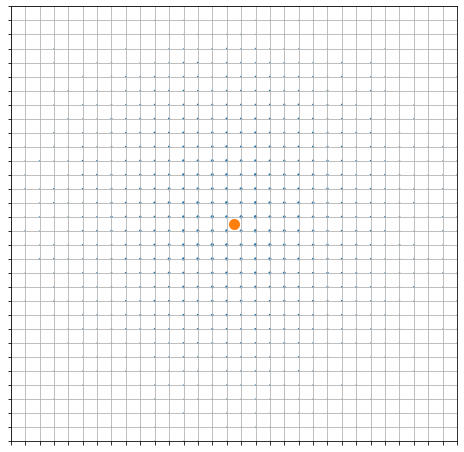

In [8]:
##################### LOT Features #####################
translations = trans_images_vox_LOT.transpose(2,0,1)
N_total = translations.shape[0]
translations = translations.reshape(N_total, -1)

#Define references. Options are "true (even number of references)", "sheared (even number of references)", "Gaussian (1 or 5)"
n_ref = 1
ref_type = "Gaussian"

grid_size = num_samplepoints
x = np.linspace(0,grid_size-1,grid_size)
y = np.linspace(0,grid_size-1,grid_size)
num_gridPoints = range(0,grid_size)
grid_points=[]
for i in range(0,grid_size):
    for j in range(0,grid_size):
        grid_points.append([x[i], y[j]])
grid_points = np.asarray(grid_points)

#Mean and covariance for a Gaussian reference distribution
if ref_type == "Gaussian":
    if n_ref == 1:
        mu = np.array([(grid_size-1)/2,(grid_size-1)/2])
        sigma = 5
        Skew = np.array([[1,0],[0,1]])
        cov = pow(sigma,2)*Skew#np.identity(2)
        GaussianSamples, GaussianReference = DiscreteGaussian(mu,cov,x,y,grid_size,10000)
    elif n_ref == 5:
        mu_center = np.array([(grid_size-1)/2, (grid_size-1)/2])
        cov_center = pow(3,2)*np.identity(2)
        mu_1 = mu_center + np.array([-(grid_size-1)/3, -(grid_size-1)/3])
        mu_2 = mu_center + np.array([-(grid_size-1)/3, (grid_size-1)/3])
        mu_3 = mu_center + np.array([(grid_size-1)/3, -(grid_size-1)/3])
        mu_4 = mu_center + np.array([(grid_size-1)/3, (grid_size-1)/3])
        cov = pow(2,2)*np.identity(2)
        GaussianSamples_center, GaussianReference_center = DiscreteGaussian(mu_center,cov_center,x,y,grid_size,10000)
        GaussianSamples_tmp, GaussianReference_sw = DiscreteGaussian(mu_1,cov,x,y,grid_size,10000)
        GaussianSamples_tmp, GaussianReference_nw = DiscreteGaussian(mu_2,cov,x,y,grid_size,10000)
        GaussianSamples_tmp, GaussianReference_se = DiscreteGaussian(mu_3,cov,x,y,grid_size,10000)
        GaussianSamples_tmp, GaussianReference_ne = DiscreteGaussian(mu_4,cov,x,y,grid_size,10000)        

if n_ref == 5 and ref_type == "Gaussian":
    fig, ax = plt.subplots(1,1)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference_center)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference_sw)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference_nw)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference_se)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference_ne)
    ax.set_xlim([0,grid_size-1])
    ax.set_ylim([0,grid_size-1])
    ax.set_xticks(num_gridPoints)
    ax.set_yticks(num_gridPoints)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.tick_params(labelbottom=False)    
    ax.tick_params(labelleft=False) 
    #ax.set(title="Five Gaussian references")
    #plt.savefig("Images/Gaussianref5.png",bbox_inches="tight",facecolor="w",dpi=500)
elif n_ref == 1 and ref_type == "Gaussian":
    fig, ax = plt.subplots(1,1)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference)
    ax.scatter(mu[0],mu[1], s = 100)
    #ax.set_title("Single Gaussian reference",fontweight="bold")
    ax.set_xlim([0,grid_size-1])
    ax.set_ylim([0,grid_size-1])
    ax.set_xticks(num_gridPoints)
    ax.set_yticks(num_gridPoints)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.tick_params(labelbottom=False)    
    ax.tick_params(labelleft=False) 
    #plt.savefig("Images/Gaussianref1.png",bbox_inches="tight",facecolor="w",dpi=500)

    
#Squared Euclidean Cost matrix between the grid points
Cost = ot.dist(grid_points, grid_points, metric = "sqeuclidean")

reference = np.empty((n_ref,grid_size**2))

#Select reference images for "true" and "sheared" types
if ref_type != "Gaussian":
    for i in range(0,int(n_ref/2)):
        tmp_indx = np.random.randint(N_total-25,N_total)
        if ref_type == "true":
            reference[i] = ReferencePoolClass1[tmp_indx].flatten()
        elif ref_type == "sheared":        
            reference[i] = Pixels[id1][tmp_indx]
        reference[i] = (1/np.sum(reference[i]))*reference[i]
        
        
    for i in range(0,int(n_ref/2)):
        tmp_indx = np.random.randint(N_total-25,N_total)
        if ref_type == "true":
            reference[int(n_ref/2)+i] = ReferencePoolClass2[tmp_indx].flatten()
        elif ref_type == "sheared":
            reference[int(n_ref/2)+i] = Pixels[id2][tmp_indx]
        reference[int(n_ref/2)+i] = (1/np.sum(reference[int(n_ref/2)+i]))*reference[int(n_ref/2)+i]

elif ref_type == "Gaussian":
    if n_ref == 1:
        reference[0] = GaussianReference
    elif n_ref == 5:
        reference[0] = GaussianReference_center
        reference[1] = GaussianReference_sw
        reference[2] = GaussianReference_nw
        reference[3] = GaussianReference_se
        reference[4] = GaussianReference_ne
    for i in range(0,n_ref):
        reference[i] = (1/np.sum(reference[i]))*reference[i]
        

        
##################### LOT Embedding #####################
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

EmbeddingClass1 = []
tic_LOT = time.perf_counter()
for i in range(0,N_total):
    template = translations[i]
    template = (1/np.sum(template))*template
        
    Embedding, Support = FullDiscreteEmbed(template,reference[0],Cost,grid_size) 
#     print('embedding shape', Embedding.shape)
    
    for j in range(1,n_ref):
        tmp1, tmp2 = FullDiscreteEmbed(template,reference[j],Cost,grid_size)
        Embedding = np.concatenate((Embedding,tmp1),axis=0)
        Support = np.concatenate((Support,tmp2),axis=0)
        del tmp1, tmp2

    EmbeddingClass1.append(Embedding)
toc_LOT = time.perf_counter() - tic_LOT    

print('time LOT',toc_LOT )

LOT_TransFeatures = np.array(EmbeddingClass1).reshape(len(EmbeddingClass1),-1)
LOT_MDSTransl = man.MDS(n_components=2,metric='euclidean',).fit_transform(LOT_TransFeatures)


 Error LOT Distance =  1.2062 % 
 Error no-coll CM Distance =  0.9643 % 
 Error no-coll GC Distance =  1.3068 %


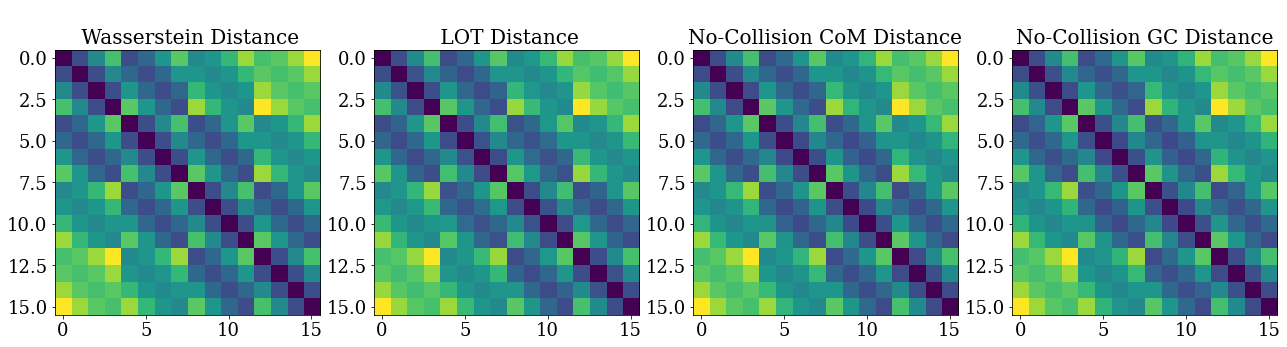

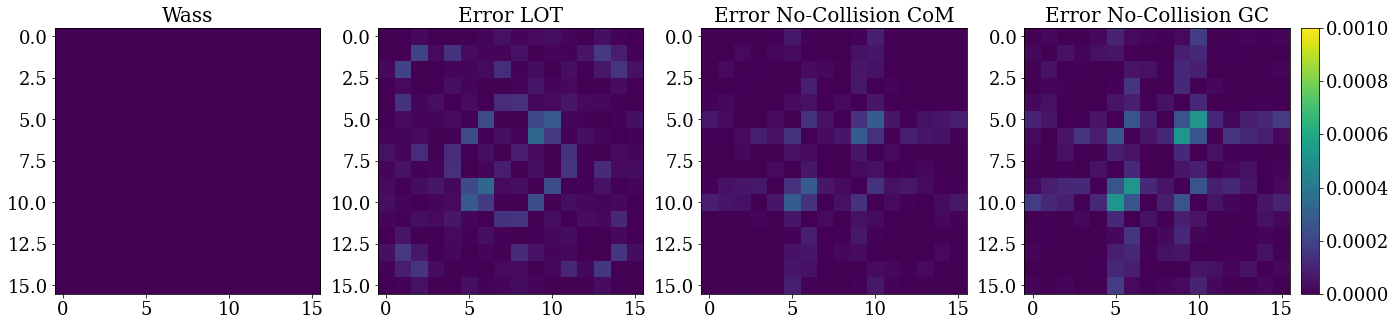

In [9]:
######### Distance Matrix Comparison ##########

LOTDist = NormalizeData(pairwiseDist(LOT_TransFeatures)**0.5)
noCMDist = NormalizeData(pairwiseDist(X_testCM)**0.5)
noGCDist = NormalizeData(pairwiseDist(X_testGC)**0.5)
Wass_distance_norm = NormalizeData(Wass_distance_trans**0.5)


print(' Error LOT Distance = ',relErr(Wass_distance_norm, LOTDist),'% \n',
'Error no-coll CM Distance = ',relErr(Wass_distance_norm, noCMDist), '% \n',
'Error no-coll GC Distance = ',relErr(Wass_distance_norm, noGCDist), '%')



fig = plt.figure(figsize=(18,5))
plt.subplot(1,4,1)
plt.imshow(Wass_distance_norm)
plt.title('\n Wasserstein Distance')

plt.subplot(1,4,2)
plt.imshow(LOTDist)
plt.title('\n LOT Distance')

plt.subplot(1,4,3)
plt.imshow(noCMDist)
plt.title('No-Collision CoM Distance')

plt.subplot(1,4,4)
plt.imshow(noGCDist)
plt.title('No-Collision GC Distance')

plt.tight_layout()
    
    
fig = plt.figure(figsize=(19.5,5))
dists =[Wass_distance_norm,LOTDist,noCMDist,noGCDist]
titles =['Wass','Error LOT','Error No-Collision CoM','Error No-Collision GC' ]
# titles
top_lim = 0.001
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.8,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 label_mode="all"
                 )

for i,ax in enumerate(grid):
    im =ax.imshow((dists[i]-Wass_distance_norm)**2, vmin=0, vmax = top_lim)
    ax.set_title(titles[i])
    
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

plt.tight_layout()  



Number of transaltion samples =  16
Time for Wass Embedding =  16.35894126095809
Time for no-collision Embedding =  0.1265364520950243
Time for LOT embedding 0.5365006509236991


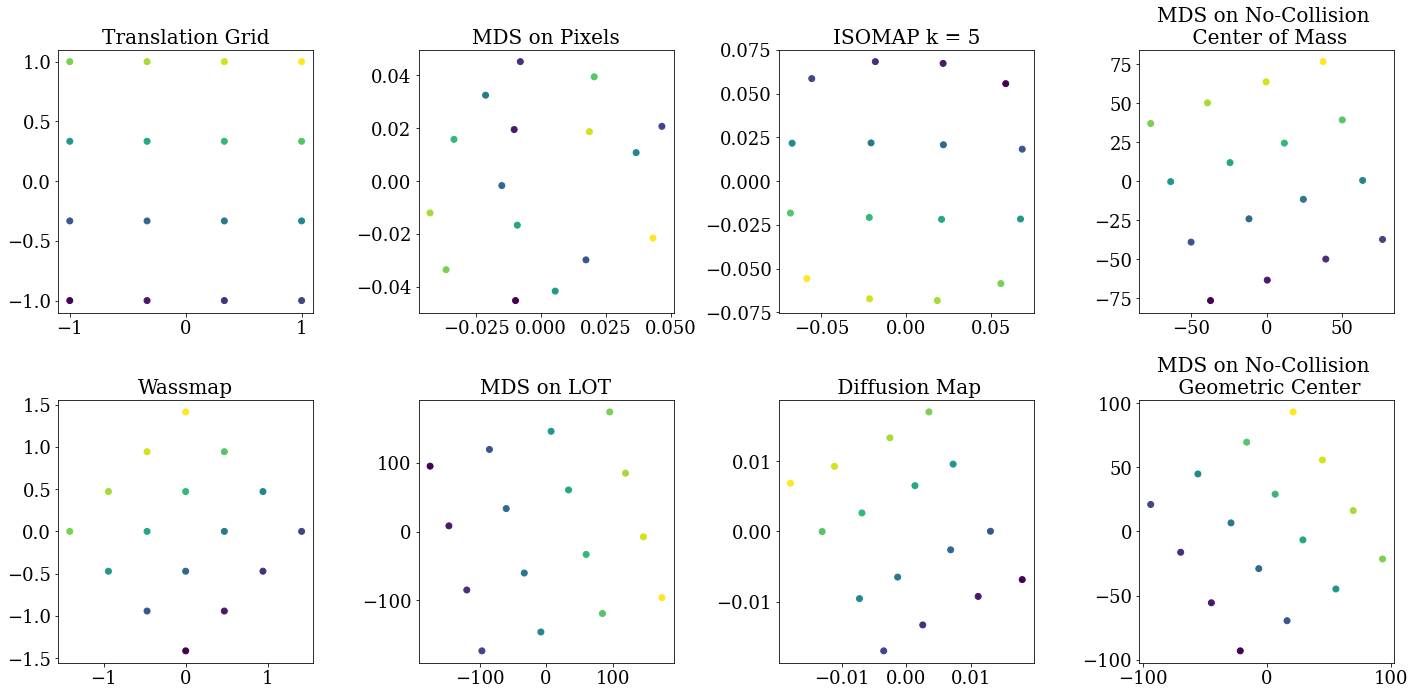

In [10]:
###################### Embedding Comparison #######################

print("Number of transaltion samples = ", num_samp)
print("Time for Wass Embedding = ", toc)
print("Time for no-collision Embedding = ",toc_NoC)
print('Time for LOT embedding',toc_LOT )

c = np.linspace(0,1,len(translates[:,0])) 

plt.figure(figsize = (20,10))
plt.subplot(241)
plt.scatter(translates[:,0],translates[:,1], c = c)
plt.title("Translation Grid")

plt.subplot(242)
scatter_x = trans_embedded_MDS[:,0]
scatter_y = trans_embedded_MDS[:,1]
plt.scatter(scatter_x, scatter_y, c = c)
plt.title("MDS on Pixels")

plt.subplot(243)
scatter_x = trans_embedded_isomap[:,0]
scatter_y = trans_embedded_isomap[:,1]
plt.scatter(scatter_x, scatter_y, c = c)
plt.title("ISOMAP k = 5")



plt.subplot(244)
scatter_x = mnist_embedded_MDS_NOcCM[:,0]
scatter_y = mnist_embedded_MDS_NOcCM[:,1]
plt.scatter(scatter_x, scatter_y, c = c)
plt.title("MDS on No-Collision \n Center of Mass")

plt.subplot(245)
scatter_x = WassEmbedding_trans[:,0]
scatter_y = WassEmbedding_trans[:,1]
plt.scatter(scatter_x,scatter_y, c = c)
plt.title("Wassmap")

plt.subplot(246)
scatter_x = LOT_MDSTransl[:,0]
scatter_y = LOT_MDSTransl[:,1]
plt.scatter(scatter_x, scatter_y, c = c)
plt.title("MDS on LOT")

plt.subplot(247)
scatter_x = trans_embedded_DiffMap[:,0]
scatter_y = trans_embedded_DiffMap[:,1]
plt.scatter(scatter_x, scatter_y, c = c)
plt.title(" Diffusion Map")

plt.subplot(248)
scatter_x = mnist_embedded_MDS_NOcGC[:,0]
scatter_y = mnist_embedded_MDS_NOcGC[:,1]
plt.scatter(scatter_x, scatter_y, c = c)
plt.title("MDS on No-Collision \n Geometric Center")






plt.tight_layout()
# plt.savefig('TranslationComparison16.png')
# plt.show()



Text(0.5, 1.0, 'Time (s) v.s. Translation Points')

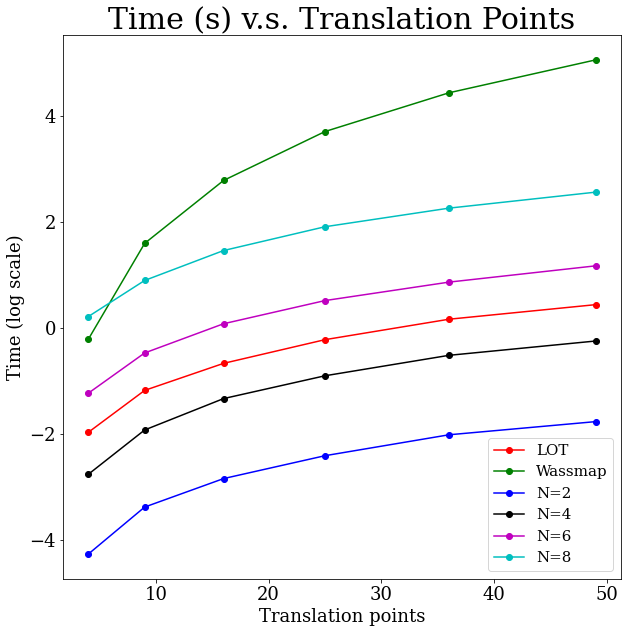

In [11]:
############### Computational Time Comparison ##################

num_samplepoints = 32
circ = generate_circle([0,0],1,samples=num_samplepoints)

tranlslating_pts = [i for i in range(2,8)]
timeLOT = []
timeWass = []
timeN2 = []
timeN4 = []
timeN6 = []
timeN8 = []
timeN10 = []
for num_translates in tranlslating_pts:
# Generate translation set
    num_samp = num_translates**2
    x = np.linspace(-1,1,num=num_translates)
    y = np.linspace(-1,1,num=num_translates)
    xx,yy = np.meshgrid(x,y) #num_translates x num_translates matrices; each xx,yy entry is a translation vector
    xx = np.reshape(xx,(num_translates**2,1))
    yy = np.reshape(yy,(num_translates**2,1))
    translates = np.zeros((num_translates**2,2))
    for i in range(len(xx)):
        translates[i,0] = xx[i]
        translates[i,1] = yy[i]

    # Generate translation images and image tensor
    trans_images = []
    for i in range(num_translates**2):
        img = np.concatenate((translation(circ,[translates[i,0],translates[i,1]]),np.ones((circ.shape[0],1))/circ.shape[0]),axis=1)
        trans_images.append(img)

    def voxel(nvox):

        # Generate voxel images (for LOT)
        nvox = nvox
        nxg = nvox
        nyg = nvox

        xg = np.linspace(-3,3,nxg)
        yg = np.linspace(-3,3,nyg)
        xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
        grid = np.stack((xxg,yyg))
        trans_images_vox = np.zeros((nvox,nvox,num_translates**2))
        for i in range(num_translates**2):
            pc = trans_images[i]
            trans_images_vox[:,:,i] = pointcloud_to_vox(pc,grid)
        return(trans_images_vox)

    trans_images_vox_LOT = voxel(num_samplepoints)
    trans_images_vox = voxel(128)
    
    #######################LOT################################
    #the reference is independent of the data so we define it only once above
    translations = trans_images_vox_LOT.transpose(2,0,1)
    N_total = translations.shape[0]
    translations = translations.reshape(N_total, -1)
        
    #EmbeddingLOT
    #Import required packages
    def warn(*args, **kwargs):
        pass
    import warnings
    warnings.warn = warn

    EmbeddingClass1 = []
    tic_LOT = time.perf_counter()
    for i in range(0,N_total):
        template = translations[i]
        template = (1/np.sum(template))*template

        Embedding, Support = FullDiscreteEmbed(template,reference[0],Cost,grid_size) 
    #     print('embedding shape', Embedding.shape)

        for j in range(1,n_ref):
            tmp1, tmp2 = FullDiscreteEmbed(template,reference[j],Cost,grid_size)
            Embedding = np.concatenate((Embedding,tmp1),axis=0)
            Support = np.concatenate((Support,tmp2),axis=0)
            del tmp1, tmp2

        EmbeddingClass1.append(Embedding)
        
    toc_LOT = time.perf_counter() - tic_LOT    
    timeLOT.append(toc_LOT)
    
    
#     ## Circle translation test :: Compute Wasserstein square distance matrix
    tic = time.perf_counter()
    Wass_distance_trans = Wasserstein_Matrix(trans_images,squared=False)
    toc = time.perf_counter() - tic
    timeWass.append(toc)
    
    NN = 2
    imgVox_NoC = trans_images_vox.T
    tic_NoC = time.perf_counter()
    X_testCM, X_testGC = features_mat(imgVox_NoC,NN)
    toc_NoC = time.perf_counter() - tic_NoC
    timeN2.append(toc_NoC)
    
    NN = 4
    imgVox_NoC = trans_images_vox.T
    tic_NoC = time.perf_counter()
    X_testCM, X_testGC = features_mat(imgVox_NoC,NN)
    toc_NoC = time.perf_counter() - tic_NoC
    timeN4.append(toc_NoC)
    
    NN = 6
    imgVox_NoC = trans_images_vox.T
    tic_NoC = time.perf_counter()
    X_testCM, X_testGC = features_mat(imgVox_NoC,NN)
    toc_NoC = time.perf_counter() - tic_NoC
    timeN6.append(toc_NoC)
    
    NN = 8
    imgVox_NoC = trans_images_vox.T
    tic_NoC = time.perf_counter()
    X_testCM, X_testGC = features_mat(imgVox_NoC,NN)
    toc_NoC = time.perf_counter() - tic_NoC
    timeN8.append(toc_NoC)
    
    NN = 10
    imgVox_NoC = trans_images_vox.T
    tic_NoC = time.perf_counter()
    X_testCM, X_testGC = features_mat(imgVox_NoC,NN)
    toc_NoC = time.perf_counter() - tic_NoC
    timeN10.append(toc_NoC)
 

tranlslating_pts = [i**2 for i in range(2,8)]
plt.figure(figsize = (10,10))

plt.plot(tranlslating_pts, np.log(timeLOT),'-o',label ='LOT', c = 'r')
plt.plot(tranlslating_pts, np.log(timeWass),'-o',label ='Wassmap', c = 'g')
plt.plot(tranlslating_pts, np.log(timeN2),'-o', label ='N=2', c = 'b')
plt.plot(tranlslating_pts, np.log(timeN4),'-o', label ='N=4', c = 'k')
plt.plot(tranlslating_pts, np.log(timeN6),'-o', label ='N=6', c = 'm')
plt.plot(tranlslating_pts, np.log(timeN8),'-o', label ='N=8', c = 'c')
plt.legend(prop={'size': 15}, loc = 'lower right')
plt.xlabel('Translation points',fontsize = 18)
plt.ylabel('Time (log scale)',fontsize = 18)
plt.title('Time (s) v.s. Translation Points', fontsize = 30)

## Translation Manifold, Example 2, Section 7.1.2

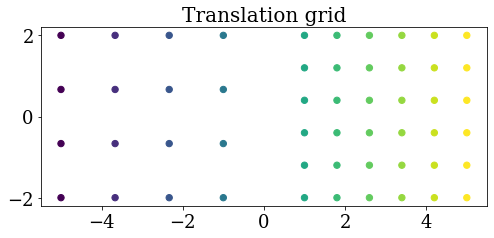

In [12]:
############# Translation Grid Genaration #########################

num_samplepoints = 32
circ = generate_circle([0,0],1,samples=num_samplepoints)

# Generate translation set 1
num_translates = 4
num_samp = num_translates**2
x = np.linspace(-5,-1,num=num_translates)
y = np.linspace(-2,2,num=num_translates)
np.random.shuffle(x) # Shuffle to make sure the order of the images doesn't matter
np.random.shuffle(y) 
xx,yy = np.meshgrid(x,y) #num_translates x num_translates matrices; each xx,yy entry is a translation vector
xx = np.reshape(xx,(num_translates**2,1))
yy = np.reshape(yy,(num_translates**2,1))
translates1 = np.zeros((num_translates**2,2))
for i in range(len(xx)):
    translates1[i,0] = xx[i]
    translates1[i,1] = yy[i]
    
# Generate translation set 2
num_translates = 6
num_samp = num_translates**2
x = np.linspace(1,5,num=num_translates)
y = np.linspace(-2,2,num=num_translates)
np.random.shuffle(x) # Shuffle to make sure the order of the images doesn't matter
np.random.shuffle(y) 
xx,yy = np.meshgrid(x,y) #num_translates x num_translates matrices; each xx,yy entry is a translation vector
xx = np.reshape(xx,(num_translates**2,1))
yy = np.reshape(yy,(num_translates**2,1))
translates2 = np.zeros((num_translates**2,2))
for i in range(len(xx)):
    translates2[i,0] = xx[i]
    translates2[i,1] = yy[i]
    
translates = np.vstack((translates1,translates2))

# Plot the translation set 
fig1,ax1 = plt.subplots()
ax1.scatter(translates[:,0],translates[:,1],s=40,c = translates[:,0])
ax1.set_aspect('equal')
ax1.set_title('Translation grid')
plt.show()


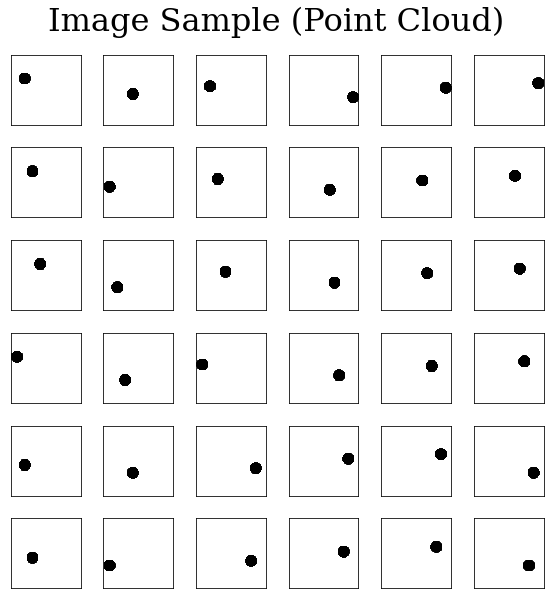

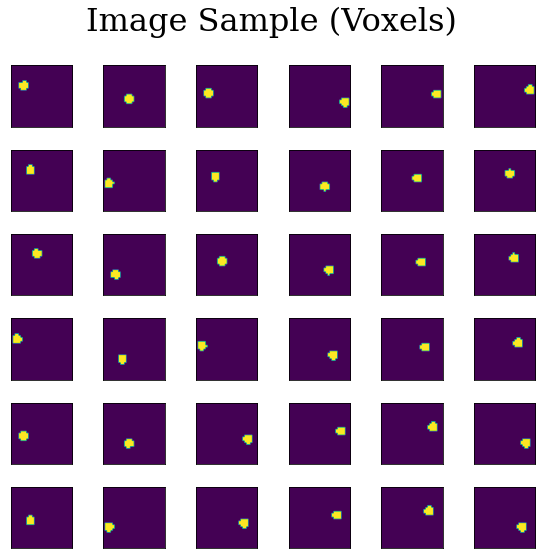

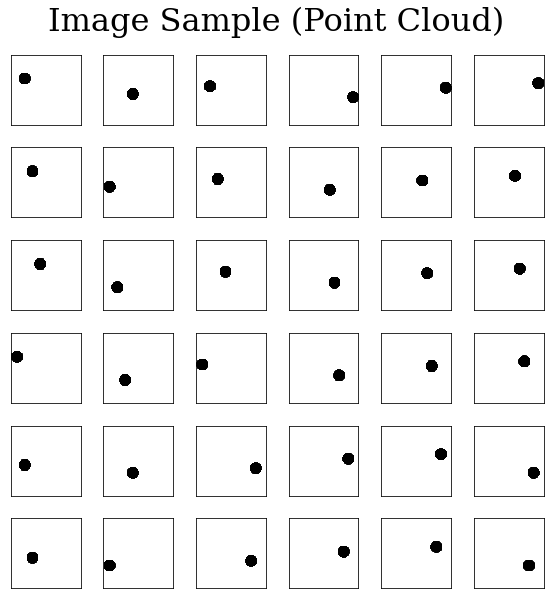

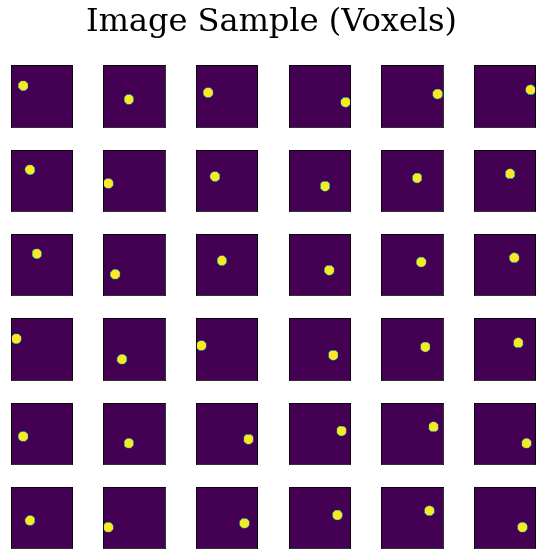

In [13]:
################ translation images and image tensor generation ######################
trans_images = []
for i in range(translates.shape[0]):
    img = np.concatenate((translation(circ,[translates[i,0],translates[i,1]]),np.ones((circ.shape[0],1))/circ.shape[0]),axis=1)
    trans_images.append(img)

    
def voxel(nvox):

    # Generate voxel images (for LOT)
    
    nvox = nvox
    nxg = nvox
    nyg = nvox

    xg = np.linspace(-6,6,nxg)
    yg = np.linspace(-6,6,nyg)
    xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
    grid = np.stack((xxg,yyg))
    trans_images_vox = np.zeros((nvox,nvox,len(trans_images)))
    for i in range(len(trans_images)):
        pc = trans_images[i]
        trans_images_vox[:,:,i] = pointcloud_to_vox(pc,grid)

    # Images not plotted here

    fig2,transaxes = plt.subplots(num_translates,num_translates)

    xtick = np.linspace(-7,7,5)
    ytick = xtick

    idx = 0
    for i in range(num_translates): 
        for j in range(num_translates):
            idx = i + num_translates*j
            xxplt = trans_images[idx][:,0]
            yyplt = trans_images[idx][:,1]
            transaxes[i,j].scatter(xxplt,yyplt,s=1,linewidths=0,c='#000000')
            transaxes[i,j].set_xlim([-6,6])
            transaxes[i,j].set_ylim([-6,6])
            transaxes[i,j].set_aspect('equal')
            transaxes[i,j].set_xticks([])
            transaxes[i,j].set_yticks([])
    fig2.tight_layout()
    fig2.suptitle('Image Sample (Point Cloud)',y=1.05,fontsize=32)

    # Voxel image figure
    fig3,transaxes_vox = plt.subplots(num_translates,num_translates)
    idx = 0
    for i in range(num_translates): 
        for j in range(num_translates):
            idx = i + num_translates*j
            transaxes_vox[i,j].imshow(trans_images_vox[:,:,idx],origin='lower',extent=(-1.5,1.5,-1.5,1.5))
            transaxes_vox[i,j].set_xticks([])
            transaxes_vox[i,j].set_yticks([])
    fig3.suptitle('Image Sample (Voxels)',fontsize=32)
    fig3.tight_layout()
    plt.show()
    
    return trans_images_vox

trans_images_vox_LOT = voxel(num_samplepoints)
trans_images_vox = voxel(128)    



In [14]:
##################### Compute Wasserstein square distance matrix #####################
tic = time.perf_counter()
Wass_distance = Wasserstein_Matrix(trans_images,squared=True)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))

#################### Wassmap Embedding: MDS on Wass squared matrix #####################

WassEmbedding = MDS(Wass_distance,squared=True)

Computed Wasserstein distance matrix (N = 36) in 178.7250 seconds


In [15]:
########### Euclidean Embeddings ##########################

temp = np.reshape(trans_images_vox.T,[trans_images_vox.shape[-1],trans_images_vox.shape[0]**2])
trans_embedded_isomap = man.Isomap(n_neighbors = 5,n_components=2,metric='euclidean').fit_transform(temp)
trans_embedded_MDS = man.MDS(n_components=2).fit_transform(temp)
trans_embedded_DiffMap = dm.DiffusionMap.from_sklearn(n_evecs = 2, epsilon = 1.0, alpha = 0.5, k=64).fit_transform(temp)

In [16]:
##################### No-collision Features #####################
NN = 2
imgVox_NoC = trans_images_vox.T

tic_NoC = time.perf_counter()
X_testCM, X_testGC = features_mat(imgVox_NoC,NN)
toc_NoC = time.perf_counter() - tic_NoC

##################### No Collision Embedding #############################
mnist_embedded_MDS_NOcCM = man.MDS(n_components=2,metric='euclidean',).fit_transform(X_testCM)
mnist_embedded_MDS_NOcGC = man.MDS(n_components=2,metric='euclidean',).fit_transform(X_testGC)



In [17]:
##################### LOT Features #####################

translations = trans_images_vox_LOT.transpose(2,0,1)
N_total = translations.shape[0]
translations = translations.reshape(N_total, -1)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

EmbeddingClass1 = []
tic_LOT = time.perf_counter()
for i in range(0,N_total):
    template = translations[i]
    template = (1/np.sum(template))*template
        
    Embedding, Support = FullDiscreteEmbed(template,reference[0],Cost,grid_size) 
#     print('embedding shape', Embedding.shape)
    
    for j in range(1,n_ref):
        tmp1, tmp2 = FullDiscreteEmbed(template,reference[j],Cost,grid_size)
        Embedding = np.concatenate((Embedding,tmp1),axis=0)
        Support = np.concatenate((Support,tmp2),axis=0)
        del tmp1, tmp2

    EmbeddingClass1.append(Embedding)
toc_LOT = time.perf_counter() - tic_LOT    

print('time LOT',toc_LOT )

LOT_TransFeatures = np.array(EmbeddingClass1).reshape(len(EmbeddingClass1),-1)



################# LOT Embedding #####################
LOT_MDSTransl = man.MDS(n_components=2,metric='euclidean',).fit_transform(LOT_TransFeatures)


time LOT 1.175366573035717


 Error LOT Distance =  1.5726 % 
 Error no-coll CM Distance =  0.3623 % 
 Error no-coll GC Distance =  0.7314 %


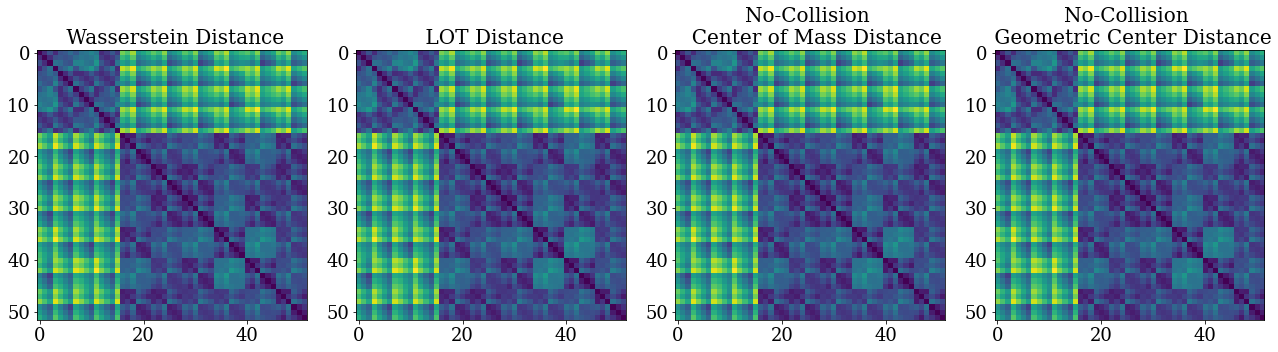

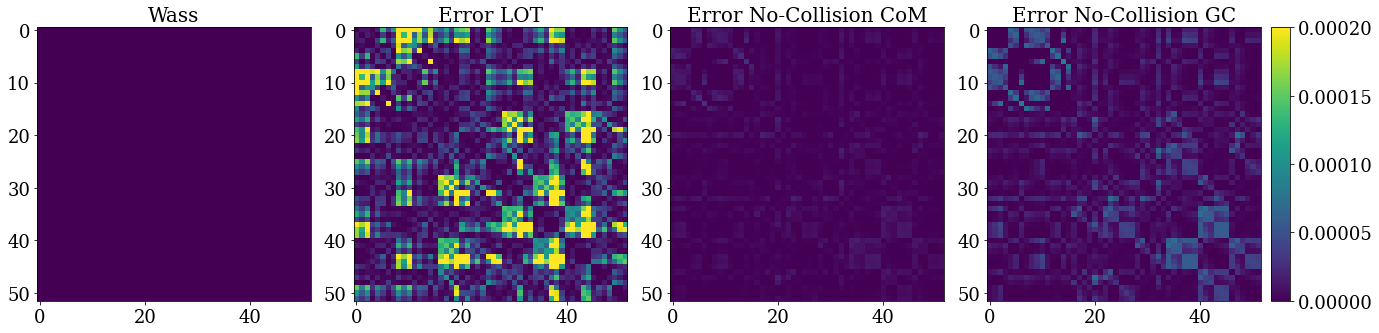

In [18]:
################# Distance Matrix Comparison #####################

LOTDist = NormalizeData(pairwiseDist(LOT_TransFeatures)**0.5)
noCMDist = NormalizeData(pairwiseDist(X_testCM)**0.5)
noGCDist = NormalizeData(pairwiseDist(X_testGC)**0.5)
Wass_distance_norm = NormalizeData(Wass_distance**0.5)

print(' Error LOT Distance = ',relErr(Wass_distance_norm, LOTDist),'% \n',
'Error no-coll CM Distance = ',relErr(Wass_distance_norm, noCMDist), '% \n',
'Error no-coll GC Distance = ',relErr(Wass_distance_norm, noGCDist), '%')

fig = plt.figure(figsize=(18,5))
plt.subplot(1,4,1)
plt.imshow(Wass_distance_norm)
plt.title('\n Wasserstein Distance')

plt.subplot(1,4,2)
plt.imshow(LOTDist)
plt.title('\n LOT Distance')


plt.subplot(1,4,3)
plt.imshow(noCMDist)
plt.title('No-Collision \n  Center of Mass Distance')

plt.subplot(1,4,4)
plt.imshow(noGCDist)
plt.title('No-Collision \n Geometric Center Distance')

plt.tight_layout()


fig = plt.figure(figsize=(19.5,5))
dists =[Wass_distance_norm,LOTDist,noCMDist,noGCDist]
titles =['Wass','Error LOT','Error No-Collision CoM','Error No-Collision GC' ]
# titles
top_lim = 0.0002
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.6,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 label_mode="all"
                 )

for i,ax in enumerate(grid):
    im =ax.imshow((dists[i]-Wass_distance_norm)**2, vmin=0, vmax = top_lim)
    ax.set_title(titles[i])
    
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

plt.tight_layout() 
    

Number of transaltion samples =  32
Time for Wass Embedding =  178.72502365906257
Time for no-collision Embedding =  0.2089875069214031
Time for LOT embedding 1.175366573035717


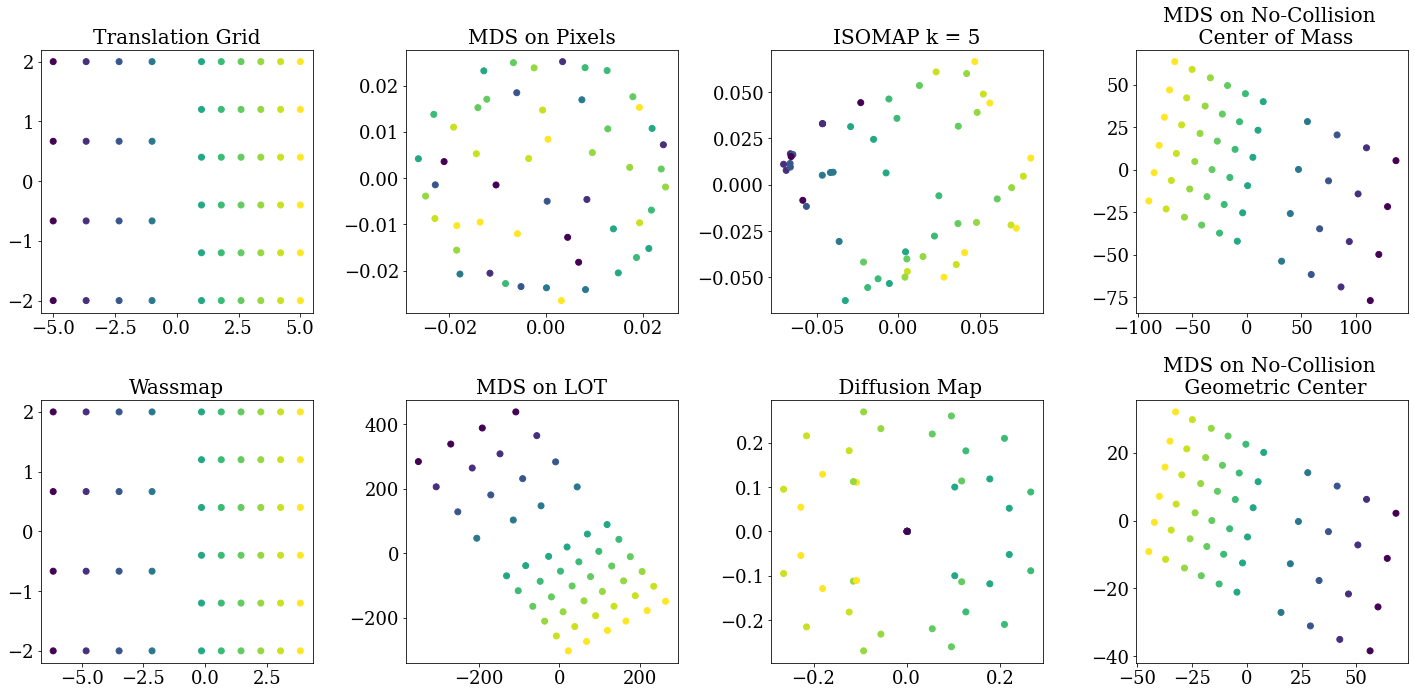

In [19]:
############# Embedding Comparison ###################

print("Number of transaltion samples = ", num_samplepoints)
print("Time for Wass Embedding = ", toc)
print("Time for no-collision Embedding = ",toc_NoC)
print('Time for LOT embedding',toc_LOT )
C = translates[:,0]


plt.figure(figsize = (20,10))
plt.subplot(241)
plt.scatter(translates[:,0],translates[:,1], c = C)
plt.title("Translation Grid")

plt.subplot(242)
scatter_x = trans_embedded_MDS[:,0]
scatter_y = trans_embedded_MDS[:,1]
plt.scatter(scatter_x, scatter_y, c = C)
plt.title("MDS on Pixels")

plt.subplot(243)
scatter_x = trans_embedded_isomap[:,0]
scatter_y = trans_embedded_isomap[:,1]
plt.scatter(scatter_x, scatter_y, c = C)
plt.title("ISOMAP k = 5")



plt.subplot(244)
scatter_x = mnist_embedded_MDS_NOcCM[:,0]
scatter_y = mnist_embedded_MDS_NOcCM[:,1]
plt.scatter(scatter_x, scatter_y, c = C)
plt.title("MDS on No-Collision \n Center of Mass")

plt.subplot(245)
scatter_x = WassEmbedding[:,0]
scatter_y = WassEmbedding[:,1]
plt.scatter(scatter_x,scatter_y, c = C)
plt.title("Wassmap")

plt.subplot(246)
scatter_x = LOT_MDSTransl[:,0]
scatter_y = LOT_MDSTransl[:,1]
plt.scatter(scatter_x, scatter_y, c = C)
plt.title("MDS on LOT")

plt.subplot(247)
scatter_x = trans_embedded_DiffMap[:,0]
scatter_y = trans_embedded_DiffMap[:,1]
plt.scatter(scatter_x, scatter_y, c = C)
plt.title(" Diffusion Map")

plt.subplot(248)
scatter_x = mnist_embedded_MDS_NOcGC[:,0]
scatter_y = mnist_embedded_MDS_NOcGC[:,1]
plt.scatter(scatter_x, scatter_y, c = C)
plt.title("MDS on No-Collision \n Geometric Center")


plt.tight_layout()

Text(0.5, 1.0, 'Time (s) v.s. Translation Points')

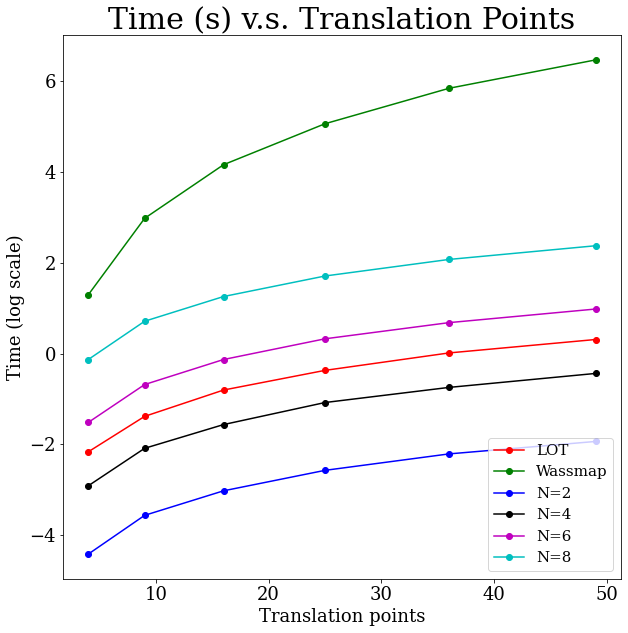

In [20]:
##################### Computational Time Comparison #######################

num_samplepoints = 32
circ = generate_circle([0,0],1,samples=num_samplepoints)

# Generate translation set 1
tranlslating_pts = [i for i in range(2,8)]
timeWass = []
timeLOT = []
timeN2 = []
timeN4 = []
timeN6 = []
timeN8 = []
timeN10 = []
for num_translates in tranlslating_pts:
    num_samp = num_translates**2
    x = np.linspace(-2,-1,num=num_translates)
    y = np.linspace(-1,1,num=num_translates)
    np.random.shuffle(x) # Shuffle to make sure the order of the images doesn't matter
    np.random.shuffle(y) 
    xx,yy = np.meshgrid(x,y) #num_translates x num_translates matrices; each xx,yy entry is a translation vector
    xx = np.reshape(xx,(num_translates**2,1))
    yy = np.reshape(yy,(num_translates**2,1))
    translates1 = np.zeros((num_translates**2,2))
    for i in range(len(xx)):
        translates1[i,0] = xx[i]
        translates1[i,1] = yy[i]

    # Generate translation set 2
    num_samp = num_translates**2
    x = np.linspace(1,2,num=num_translates)
    y = np.linspace(-1,1,num=num_translates)
    np.random.shuffle(x) # Shuffle to make sure the order of the images doesn't matter
    np.random.shuffle(y) 
    xx,yy = np.meshgrid(x,y) #num_translates x num_translates matrices; each xx,yy entry is a translation vector
    xx = np.reshape(xx,(num_translates**2,1))
    yy = np.reshape(yy,(num_translates**2,1))
    translates2 = np.zeros((num_translates**2,2))
    for i in range(len(xx)):
        translates2[i,0] = xx[i]
        translates2[i,1] = yy[i]

    translates = np.vstack((translates1,translates2))
    
    # Generate translation images and image tensor
    trans_images = []
    for i in range(translates.shape[0]):
        img = np.concatenate((translation(circ,[translates[i,0],translates[i,1]]),np.ones((circ.shape[0],1))/circ.shape[0]),axis=1)
        trans_images.append(img)

        
        
    def voxel(nvox):

        # Generate voxel images (for LOT)
        nvox = nvox
        nxg = nvox
        nyg = nvox

        xg = np.linspace(-4,4,nxg)
        yg = np.linspace(-4,4,nyg)
        xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
        grid = np.stack((xxg,yyg))
        trans_images_vox = np.zeros((nvox,nvox,num_translates**2))
        for i in range(num_translates**2):
            pc = trans_images[i]
            trans_images_vox[:,:,i] = pointcloud_to_vox(pc,grid)
        return(trans_images_vox)

    trans_images_vox_LOT = voxel(num_samplepoints)
    trans_images_vox = voxel(128)
    
    #######################LOT################################
    #the reference is independent of the data so we define it only once above
    translations = trans_images_vox_LOT.transpose(2,0,1)
    N_total = translations.shape[0]
    translations = translations.reshape(N_total, -1)
    
    #EmbeddingLOT
    #Import required packages
    def warn(*args, **kwargs):
        pass
    import warnings
    warnings.warn = warn

    EmbeddingClass1 = []
    tic_LOT = time.perf_counter()
    for i in range(0,N_total):
        template = translations[i]
        template = (1/np.sum(template))*template

        Embedding, Support = FullDiscreteEmbed(template,reference[0],Cost,grid_size) 
    #     print('embedding shape', Embedding.shape)

        for j in range(1,n_ref):
            tmp1, tmp2 = FullDiscreteEmbed(template,reference[j],Cost,grid_size)
            Embedding = np.concatenate((Embedding,tmp1),axis=0)
            Support = np.concatenate((Support,tmp2),axis=0)
            del tmp1, tmp2

        EmbeddingClass1.append(Embedding)
        
    toc_LOT = time.perf_counter() - tic_LOT    
    timeLOT.append(toc_LOT)


    ## Circle translation test :: Compute Wasserstein square distance matrix
    tic = time.perf_counter()
    Wass_distance_trans = Wasserstein_Matrix(trans_images,squared=False)
    toc = time.perf_counter() - tic
    timeWass.append(toc)
    
    NN = 2
    imgVox_NoC = trans_images_vox.T
    tic_NoC = time.perf_counter()
    X_testCM, X_testGC = features_mat(imgVox_NoC,NN)
    toc_NoC = time.perf_counter() - tic_NoC
    timeN2.append(toc_NoC)
    
    NN = 4
    imgVox_NoC = trans_images_vox.T
    tic_NoC = time.perf_counter()
    X_testCM, X_testGC = features_mat(imgVox_NoC,NN)
    toc_NoC = time.perf_counter() - tic_NoC
    timeN4.append(toc_NoC)
    
    NN = 6
    imgVox_NoC = trans_images_vox.T
    tic_NoC = time.perf_counter()
    X_testCM, X_testGC = features_mat(imgVox_NoC,NN)
    toc_NoC = time.perf_counter() - tic_NoC
    timeN6.append(toc_NoC)
    
    NN = 8
    imgVox_NoC = trans_images_vox.T
    tic_NoC = time.perf_counter()
    X_testCM, X_testGC = features_mat(imgVox_NoC,NN)
    toc_NoC = time.perf_counter() - tic_NoC
    timeN8.append(toc_NoC)
    
    
    
tranlslating_pts = [i**2 for i in range(2,8)]
plt.figure(figsize = (10,10))

plt.plot(tranlslating_pts, np.log(timeLOT),'-o',label ='LOT', c = 'r')
plt.plot(tranlslating_pts, np.log(timeWass),'-o',label ='Wassmap', c = 'g')
plt.plot(tranlslating_pts, np.log(timeN2),'-o', label ='N=2', c = 'b')
plt.plot(tranlslating_pts, np.log(timeN4),'-o', label ='N=4', c = 'k')
plt.plot(tranlslating_pts, np.log(timeN6),'-o', label ='N=6', c = 'm')
plt.plot(tranlslating_pts, np.log(timeN8),'-o', label ='N=8', c = 'c')
plt.legend(prop={'size': 15}, loc = 'lower right')
plt.xlabel('Translation points',fontsize = 18)
plt.ylabel('Time (log scale)',fontsize = 18)
plt.title('Time (s) v.s. Translation Points', fontsize = 30)

## Translation Manifold, Example 3, Section 7.1.3

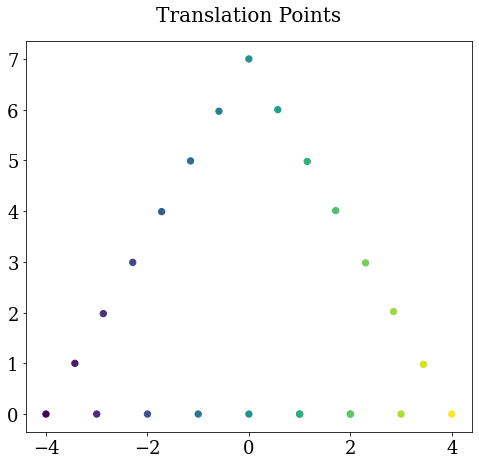

In [21]:
############# Translation Grid Genaration #########################

num_samplepoints = 32
circle = generate_circle([0,0],1,samples=num_samplepoints)

# Generate Translation set
num_transl = 24
theta = np.array([[0,0],[-4,0],[4,0], [0,7],[-3,0],[-2,0],[-1,0],[1,0],[2,0],[1,0],[2,0],[3,0],[-3.43,1],[-2.87,1.98],[-2.29,2.99],[-1.72,3.99],[-1.15,4.99],[-0.59,5.97],[0.57,6],[1.15,4.98],[1.71,4.01],[2.3,2.98],[2.85,2.02],[3.44,0.98]])

translates = theta 

# Plot the Translation set 
fig1,ax1 = plt.subplots()
ax1.scatter(translates[:,0],translates[:,1],s=40, c=translates[:,0])
ax1.set_aspect('equal')
ax1.set_title('Translation Points',pad=20)
plt.show()



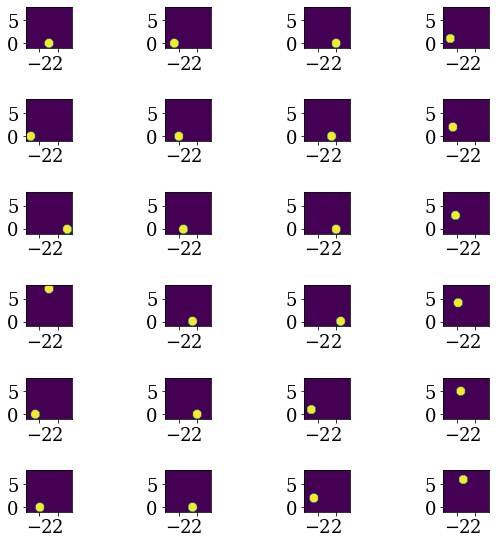

In [22]:
################ translation images and image tensor generation ######################

trans_images = []
for i in range(translates.shape[0]):
    img = np.concatenate((translation(circle,theta[i]),np.ones((circle.shape[0],1))/circle.shape[0]),axis=1)
    trans_images.append(img)
    
# Generate Translation image tensor for display purposes
trans_images2 = np.zeros((circle.shape[0],circle.shape[1],num_transl))
for i in range(translates.shape[0]):
    trans_images2[:,:,i] = translation(circle,theta[i])


def voxel(nvox):

    # Generate voxel images (for LOT)
    nvox = nvox
    nxg = nvox
    nyg = nvox

    xg = np.linspace(-5,5,nxg)
    yg = np.linspace(-1,8,nyg)
    xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
    grid = np.stack((xxg,yyg))
    trans_images_vox = np.zeros((nvox,nvox,len(trans_images)))
    for i in range(len(trans_images)):
        pc = trans_images[i]
        trans_images_vox[:,:,i] = pointcloud_to_vox(pc,grid)
    return(trans_images_vox)

trans_images_vox_LOT = voxel(num_samplepoints)
trans_images_vox = voxel(128)

fig3,translates_vox = plt.subplots(6,4)
fig3.tight_layout()

idx = 0
for i in range(6): 
    for j in range(4):
        idx = i + 4*j
        translates_vox[i,j].imshow(trans_images_vox[:,:,idx],origin='lower',extent = (-5,5,-1,8))
        translates_vox[i,j].set_xticks([-2,2])
plt.show()


In [23]:
##################### Compute Wasserstein square distance matrix #####################

tic = time.perf_counter()
Wass_distance_trans = Wasserstein_Matrix(trans_images,squared=True)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))


#################### Wassmap Embedding: MDS on Wass squared matrix #####################
WassEmbedding_trans = MDS(Wass_distance_trans,squared=True)

Computed Wasserstein distance matrix (N = 49) in 37.0367 seconds


In [24]:
########### Euclidean Embeddings ##########################

temp = np.reshape(trans_images_vox.T,[trans_images_vox.shape[-1],trans_images_vox.shape[0]**2])
trans_embedded_isomap = man.Isomap(n_neighbors=5,n_components=2,metric='euclidean').fit_transform(temp)
trans_embedded_MDS = man.MDS(n_components=2).fit_transform(temp)
trans_embedded_DiffMap = dm.DiffusionMap.from_sklearn(n_evecs = 2, epsilon = 'bgh', alpha = 0.5, k=64).fit_transform(temp)

In [25]:
##################### No-collision Features #####################

imgVox_NoC = trans_images_vox.T
NNCM = 4

NNGC = 2

X_testCM, _ = features_mat(imgVox_NoC,NNCM)

tic_NoC = time.perf_counter()
_, X_testGC = features_mat(imgVox_NoC,NNGC)
toc_NoC = time.perf_counter() - tic_NoC

##################### No-collision Embedding #####################
mnist_embedded_MDS_NOcCM = man.MDS(n_components=2,metric='euclidean',).fit_transform(X_testCM)
mnist_embedded_MDS_NOcGC = man.MDS(n_components=2,metric='euclidean',).fit_transform(X_testGC)


In [26]:
##################### LOT Features #####################

translations = trans_images_vox_LOT.transpose(2,0,1)
N_total = translations.shape[0]
translations = translations.reshape(N_total, -1)


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

EmbeddingClass1 = []
tic_LOT = time.perf_counter()
for i in range(0,N_total):
    template = translations[i]
    template = (1/np.sum(template))*template
        
    Embedding, Support = FullDiscreteEmbed(template,reference[0],Cost,grid_size) 
#     print('embedding shape', Embedding.shape)
    
    for j in range(1,n_ref):
        tmp1, tmp2 = FullDiscreteEmbed(template,reference[j],Cost,grid_size)
        Embedding = np.concatenate((Embedding,tmp1),axis=0)
        Support = np.concatenate((Support,tmp2),axis=0)
        del tmp1, tmp2

    EmbeddingClass1.append(Embedding)
toc_LOT = time.perf_counter() - tic_LOT    

print('time LOT',toc_LOT )

LOT_TransFeatures = np.array(EmbeddingClass1).reshape(len(EmbeddingClass1),-1)

##################### LOT Embedding #####################

LOT_MDSTransl = man.MDS(n_components=2,metric='euclidean',).fit_transform(LOT_TransFeatures)


time LOT 0.5783419919898733


 Error LOT Distance =  4.7974 % 
 Error no-coll CM Distance =  4.6283 % 
 Error no-coll GC Distance =  4.5619 %


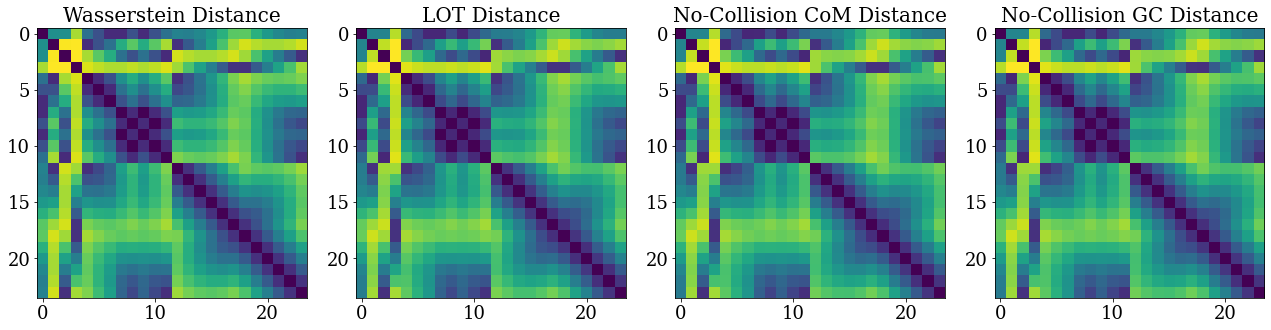

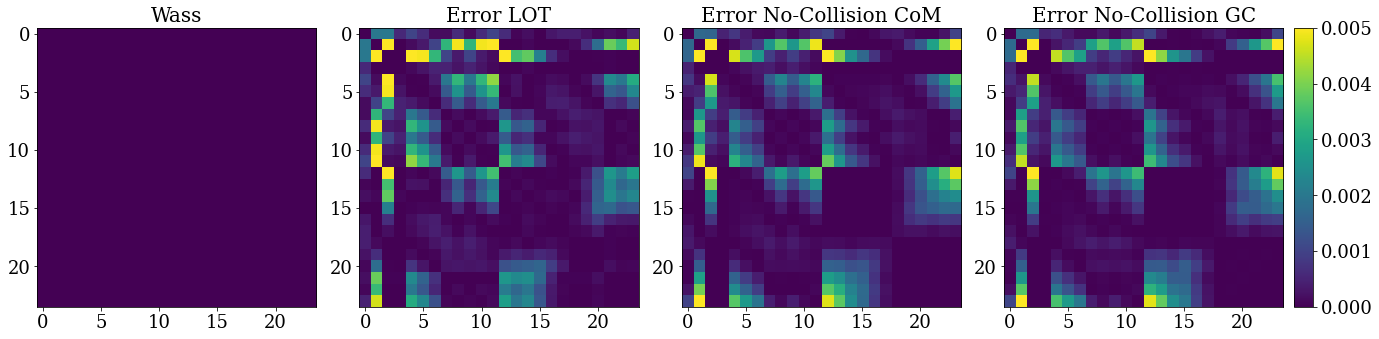

In [27]:
##################### Distance Matrix Comparison #####################

LOTDist = NormalizeData(pairwiseDist(LOT_TransFeatures)**0.5)
noCMDist = NormalizeData(pairwiseDist(X_testCM)**0.5)
noGCDist = NormalizeData(pairwiseDist(X_testGC)**0.5)
Wass_distance_norm = NormalizeData(Wass_distance_trans**0.5)

print(' Error LOT Distance = ',relErr(Wass_distance_norm, LOTDist),'% \n',
'Error no-coll CM Distance = ',relErr(Wass_distance_norm, noCMDist), '% \n',
'Error no-coll GC Distance = ',relErr(Wass_distance_norm, noGCDist), '%')

fig = plt.figure(figsize=(18,5))
plt.subplot(1,4,1)
plt.imshow(Wass_distance_norm)
plt.title('Wasserstein Distance')

plt.subplot(1,4,2)
plt.imshow(LOTDist)
plt.title('LOT Distance')


plt.subplot(1,4,3)
plt.imshow(noCMDist)
plt.title('No-Collision CoM Distance')

plt.subplot(1,4,4)
plt.imshow(noGCDist)
plt.title('No-Collision GC Distance')

plt.tight_layout()


fig = plt.figure(figsize=(19.5,5))
dists =[Wass_distance_norm,LOTDist,noCMDist,noGCDist]
titles =['Wass','Error LOT','Error No-Collision CoM','Error No-Collision GC' ]
# titles
top_lim = 0.005
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.6,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 label_mode="all"
                 )

for i,ax in enumerate(grid):
    im =ax.imshow((dists[i]-Wass_distance_norm)**2, vmin=0, vmax = top_lim)
    ax.set_title(titles[i])
    
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

plt.tight_layout() 
    

Number of transaltion samples =  49
Time for Wass Embedding =  37.03671158594079
Time for no-collision Embedding =  0.08139874797780067
Time for LOT embedding 0.5783419919898733


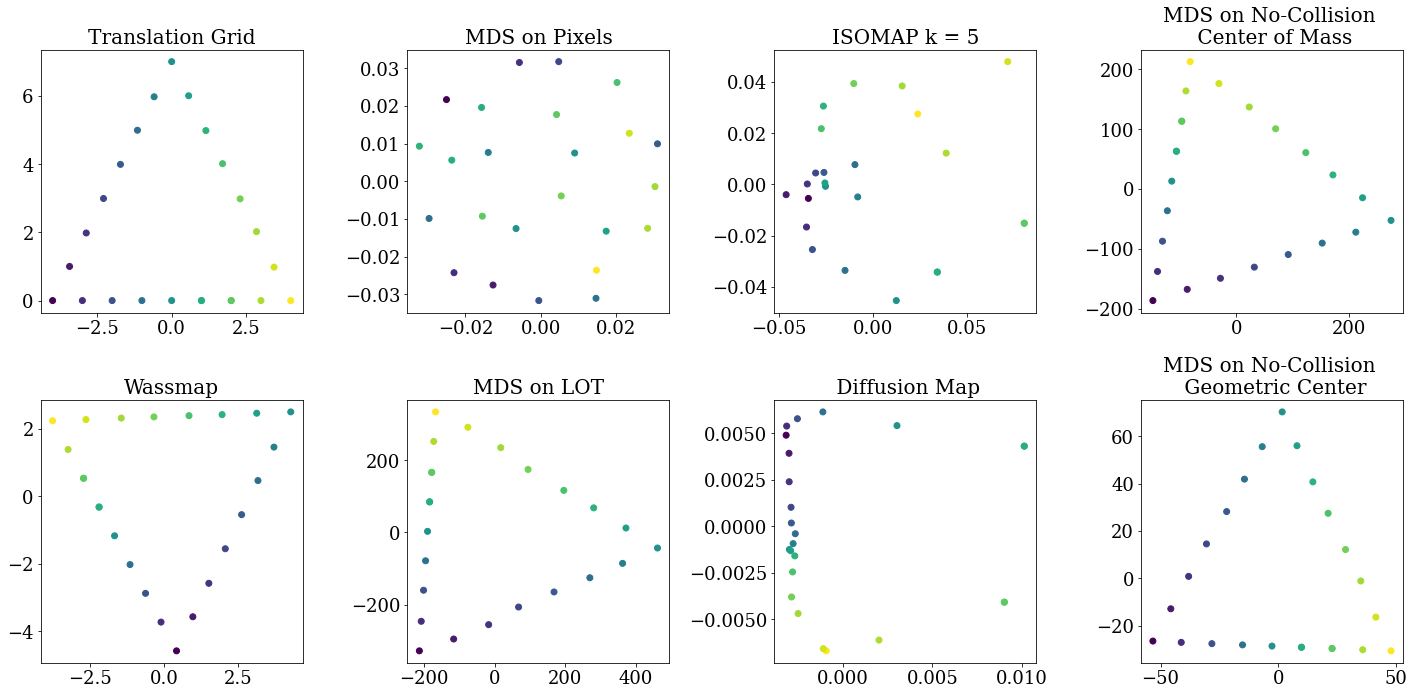

In [28]:
##################### Embedding Comparison #####################

print("Number of transaltion samples = ", num_samp)
print("Time for Wass Embedding = ", toc)
print("Time for no-collision Embedding = ",toc_NoC)
print('Time for LOT embedding',toc_LOT )

c = translates[:,0]

plt.figure(figsize = (20,10))
plt.subplot(241)
plt.scatter(translates[:,0],translates[:,1], c = c)
plt.title("Translation Grid")

plt.subplot(242)
scatter_x = trans_embedded_MDS[:,0]
scatter_y = trans_embedded_MDS[:,1]
plt.scatter(scatter_x, scatter_y, c = c)
plt.title("MDS on Pixels")

plt.subplot(243)
scatter_x = trans_embedded_isomap[:,0]
scatter_y = trans_embedded_isomap[:,1]
plt.scatter(scatter_x, scatter_y, c = c)
plt.title("ISOMAP k = 5")



plt.subplot(244)
scatter_x = mnist_embedded_MDS_NOcCM[:,0]
scatter_y = mnist_embedded_MDS_NOcCM[:,1]
plt.scatter(scatter_x, scatter_y, c = c)
plt.title("MDS on No-Collision \n Center of Mass")

plt.subplot(245)
scatter_x = WassEmbedding_trans[:,0]
scatter_y = WassEmbedding_trans[:,1]
plt.scatter(scatter_x,scatter_y, c = c)
plt.title("Wassmap")

plt.subplot(246)
scatter_x = LOT_MDSTransl[:,0]
scatter_y = LOT_MDSTransl[:,1]
plt.scatter(scatter_x, scatter_y, c = c)
plt.title("MDS on LOT")

plt.subplot(247)
scatter_x = trans_embedded_DiffMap[:,0]
scatter_y = trans_embedded_DiffMap[:,1]
plt.scatter(scatter_x, scatter_y, c = c)
plt.title(" Diffusion Map")

plt.subplot(248)
scatter_x = mnist_embedded_MDS_NOcGC[:,0]
scatter_y = mnist_embedded_MDS_NOcGC[:,1]
plt.scatter(scatter_x, scatter_y, c = c)
plt.title("MDS on No-Collision \n Geometric Center")


plt.tight_layout()